# Get the data

For xgboost and sklearn.tree you will need to convert categorical variables to dummies.

In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split

df = sns.load_dataset("titanic")
df = df.drop("alive", axis=1)
char_cols = df.select_dtypes(include=['object','bool','category']).columns.to_list()
char_cols
df = pd.get_dummies(
    data=df,
    dummy_na=True,
    columns=char_cols,
    dtype=int
)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   survived                 891 non-null    int64  
 1   pclass                   891 non-null    int64  
 2   age                      714 non-null    float64
 3   sibsp                    891 non-null    int64  
 4   parch                    891 non-null    int64  
 5   fare                     891 non-null    float64
 6   sex_female               891 non-null    int32  
 7   sex_male                 891 non-null    int32  
 8   sex_nan                  891 non-null    int32  
 9   embarked_C               891 non-null    int32  
 10  embarked_Q               891 non-null    int32  
 11  embarked_S               891 non-null    int32  
 12  embarked_nan             891 non-null    int32  
 13  class_First              891 non-null    int32  
 14  class_Second             8

# Split the data into train and validation

In [8]:
y = df[["survived"]]
x = df.drop("survived", axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# Tree example

This does not work very well, but for your data it may be ok.

[Text(0.41140761927945474, 0.9736842105263158, 'x[21] <= 0.5\ngini = 0.467\nsamples = 596\nvalue = [374, 222]'),
 Text(0.1711295034079844, 0.9210526315789473, 'x[0] <= 2.5\ngini = 0.425\nsamples = 235\nvalue = [72, 163]'),
 Text(0.05063291139240506, 0.868421052631579, 'x[25] <= 0.5\ngini = 0.068\nsamples = 114\nvalue = [4, 110]'),
 Text(0.023369036027263874, 0.8157894736842105, 'x[4] <= 22.0\ngini = 0.021\nsamples = 93\nvalue = [1, 92]'),
 Text(0.01557935735150925, 0.7631578947368421, 'x[4] <= 20.25\ngini = 0.067\nsamples = 29\nvalue = [1, 28]'),
 Text(0.007789678675754625, 0.7105263157894737, 'gini = 0.0\nsamples = 27\nvalue = [0, 27]'),
 Text(0.023369036027263874, 0.7105263157894737, 'x[2] <= 2.0\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.01557935735150925, 0.6578947368421053, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.0311587147030185, 0.6578947368421053, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.0311587147030185, 0.7631578947368421, 'gini = 0.0\nsamples 

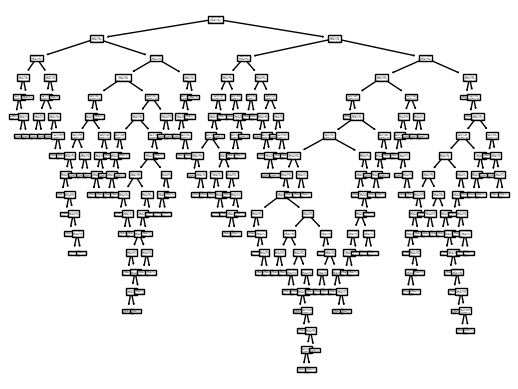

In [9]:
classifier = tree.DecisionTreeClassifier()
classifier = classifier.fit(x_train, y_train)
tree.plot_tree(classifier)

# XGBoost

This is far better than a single tree and should be immune to overfitting.

The downside is that you will have to tune the parameters, but you should just try something like this and see what you get.

In [91]:
import xgboost as xgb
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dtest = xgb.DMatrix(data=x_test, label=y_test)
evaluation = [(dtest, "test"), (dtrain, "train")]
results = {}
booster = xgb.train(
    dtrain=dtrain,
    params={
        "booster":"gbtree",
        "device":"cuda",
        "objective":"binary:logistic",
        "eval_metric":"auc",
        "eta":0.01,
        # "subsample": 0.5
    },
    num_boost_round=10000,
    evals=evaluation,
    early_stopping_rounds=20,
    verbose_eval=100,
    evals_result=results
)  

[0]	test-auc:0.86736	train-auc:0.90546
[100]	test-auc:0.84948	train-auc:0.93773
[200]	test-auc:0.85426	train-auc:0.95091
[300]	test-auc:0.86162	train-auc:0.96484
[400]	test-auc:0.86486	train-auc:0.96806
[500]	test-auc:0.86452	train-auc:0.97210
[600]	test-auc:0.86264	train-auc:0.97663
[700]	test-auc:0.86140	train-auc:0.98061
[800]	test-auc:0.85769	train-auc:0.98359
[900]	test-auc:0.85536	train-auc:0.98625
[1000]	test-auc:0.85469	train-auc:0.98803
[1100]	test-auc:0.85414	train-auc:0.99020
[1200]	test-auc:0.85267	train-auc:0.99109
[1300]	test-auc:0.84986	train-auc:0.99203
[1400]	test-auc:0.84824	train-auc:0.99292
[1464]	test-auc:0.84752	train-auc:0.99326


## Evaluate parameters

Evaluate the learning rate and especially early stopping rounds.

(0.8, 1.0)

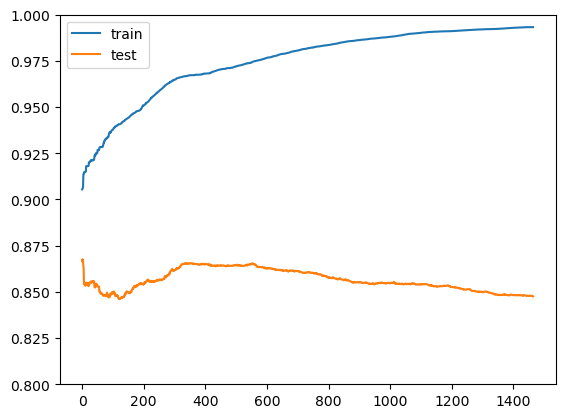

In [92]:
test_auc = results["test"]["auc"]
train_auc = results["train"]["auc"]

plt.figure(0).clf()
plt.plot(train_auc,label="train")
plt.plot(test_auc, label="test")

plt.legend(loc=0)
ax = plt.gca()
ax.set_ylim([0.8,1])

In [93]:
from sklearn.metrics import roc_auc_score, roc_curve

train_auc = roc_auc_score(y_train, booster.predict(dtrain))
validation_auc = roc_auc_score(y_test, booster.predict(dtest))
print(f"Train: {train_auc:.4f} Validation: {validation_auc:.4f}")

Train: 0.9933 Validation: 0.8475


## Evaluate model performance

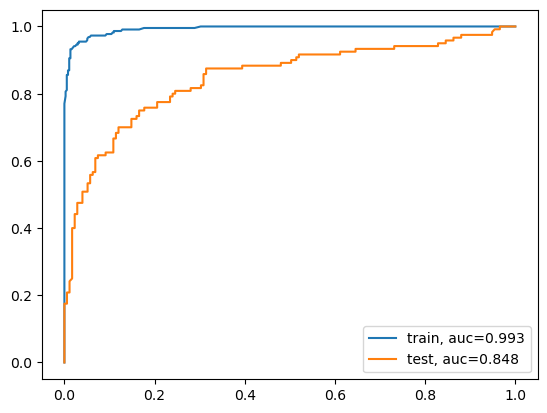

In [94]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(0).clf()

fpr, tpr, thresh = roc_curve(y_train, booster.predict(dtrain))
auc = roc_auc_score(y_train, booster.predict(dtrain))
plt.plot(fpr,tpr,label=f"train, auc={auc:.3f}")

fpr, tpr, thresh = roc_curve(y_test, booster.predict(dtest))
auc = roc_auc_score(y_test, booster.predict(dtest))
plt.plot(fpr,tpr,label=f"test, auc={auc:.3f}")

plt.legend(loc=0)

## Score performance on the validation population

In [98]:
validation = pd.concat([x_test, y_test], axis=1)
prediction = booster.predict(dtest)
validation = validation.assign(pred = prediction). \
    assign(score = lambda x: round(x.pred * 1000)). \
        assign(score_decile = lambda x: pd.qcut(x.score, q=10, labels=False))

aggr = validation.groupby('score_decile', as_index=False).agg(c = ('survived', 'count'), survived = ('survived', 'sum')).assign(pct = lambda x: x.survived / x.c)
aggr

,score_decile,c,survived,pct
0,0,30,5,0.166667
1,1,30,3,0.100000
2,2,30,2,0.066667
3,3,28,4,0.142857
4,4,30,8,0.266667
5,5,29,9,0.310345
6,6,29,15,0.517241
7,7,30,20,0.666667
8,8,30,27,0.900000
9,9,29,27,0.931034


c:\Users\littl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\littl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='score_decile', ylabel='pct'>

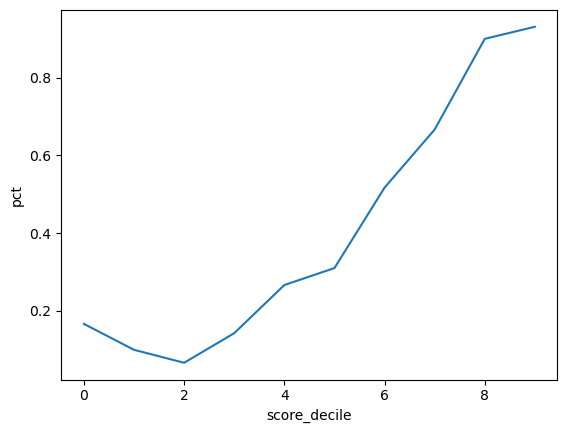

In [99]:
sns.lineplot(aggr, x="score_decile", y="pct")

# Important - feature importance

Evaluate feature importance for the features in the model.

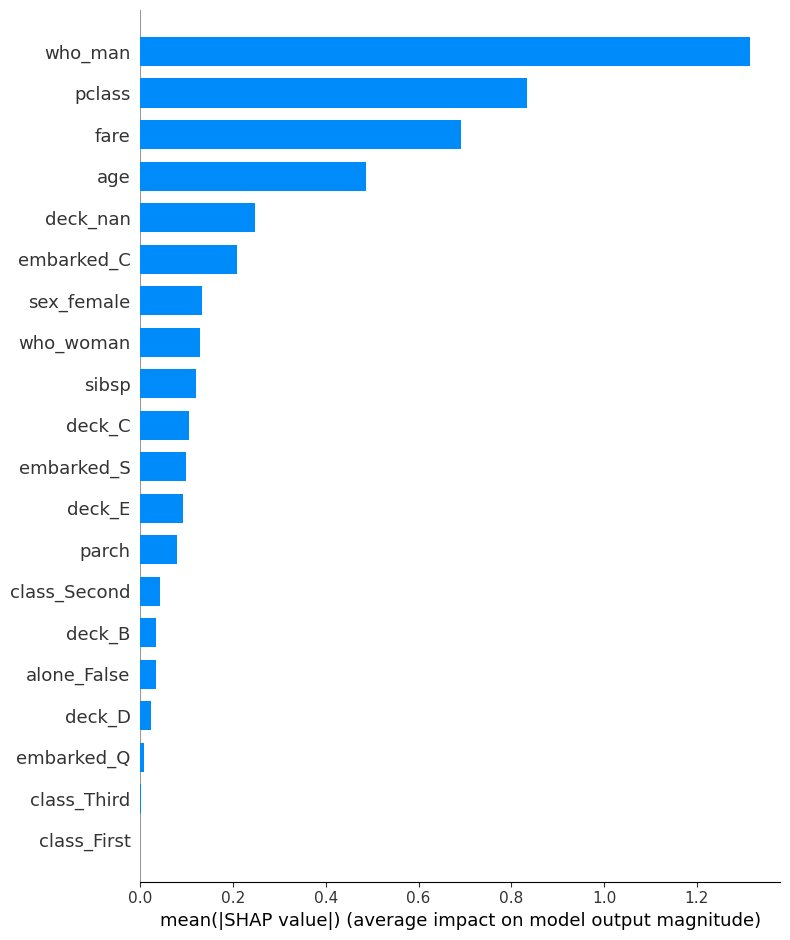

In [100]:
import shap
explainer = shap.TreeExplainer(booster)
shapvalues = explainer.shap_values(x_train)
shap.summary_plot(shapvalues, x_train, plot_type="bar")